### Packages

In [3]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

### Loading ordered data from data_clean_order_text.ipynb

In [4]:
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [5]:
# Experimental data orderings on headlines TRAIN EXAMPLES
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
Y1_train = ordered_super_alpha_text['class']
Y2_train = ordered_class_alpha_text['class']
Y3_train = ordered_sem_clusters_desc_text['class']
Y4_train = ordered_sem_clusters_asc_text['class']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['class']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['class']



In [6]:
Y1_train[:100]

0      BLACK VOICES
1     LATINO VOICES
2      QUEER VOICES
3      QUEER VOICES
4      QUEER VOICES
          ...      
95     QUEER VOICES
96     BLACK VOICES
97    LATINO VOICES
98     BLACK VOICES
99     BLACK VOICES
Name: class, Length: 100, dtype: object

In [7]:
Y2_train[:100]

0     ARTS
1     ARTS
2     ARTS
3     ARTS
4     ARTS
      ... 
95    ARTS
96    ARTS
97    ARTS
98    ARTS
99    ARTS
Name: class, Length: 100, dtype: object

In [8]:
Y3_train[:100]

68504    GENERAL POLITICS
69260    GENERAL POLITICS
99276    GENERAL POLITICS
68220    GENERAL POLITICS
56955    GENERAL POLITICS
               ...       
86926    GENERAL POLITICS
51250    GENERAL POLITICS
35939    GENERAL POLITICS
18413    GENERAL POLITICS
27379    GENERAL POLITICS
Name: class, Length: 100, dtype: object

In [9]:
Y4_train[:100]

207438    CULTURE & ARTS
193271    CULTURE & ARTS
201761    CULTURE & ARTS
146673    CULTURE & ARTS
190637    CULTURE & ARTS
               ...      
153890    CULTURE & ARTS
171095    CULTURE & ARTS
143223    CULTURE & ARTS
169032    CULTURE & ARTS
195877    CULTURE & ARTS
Name: class, Length: 100, dtype: object

In [10]:
Y5_train[:100]

72180     GOOD NEWS
112162    GOOD NEWS
74004     GOOD NEWS
97834     GOOD NEWS
96919     GOOD NEWS
            ...    
57938     GOOD NEWS
96668     GOOD NEWS
70744     GOOD NEWS
62196     GOOD NEWS
69314     GOOD NEWS
Name: class, Length: 100, dtype: object

In [11]:
Y_test[:100]

166912           PARENTING
137790              TRAVEL
153816      CULTURE & ARTS
23683     GENERAL POLITICS
173834            WELLNESS
                ...       
187842      STYLE & BEAUTY
115679               MEDIA
7876      GENERAL POLITICS
31449                STYLE
45309                STYLE
Name: class, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [12]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 27262


# EXPERIMENT ORDER 1

In [13]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model training using embedding layer and RNN (Baseline)

In [14]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            3755150   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 42)                1

In [15]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

Epoch 1/15
1310/1310 [==============================] - 105s 74ms/step - loss: 2.7881 - accuracy: 0.3064
Epoch 2/15
1310/1310 [==============================] - 96s 73ms/step - loss: 2.1373 - accuracy: 0.4523
Epoch 3/15
1310/1310 [==============================] - 101s 77ms/step - loss: 1.9236 - accuracy: 0.4991
Epoch 4/15
1310/1310 [==============================] - 101s 77ms/step - loss: 1.7838 - accuracy: 0.5312
Epoch 5/15
1310/1310 [==============================] - 110s 84ms/step - loss: 1.6839 - accuracy: 0.5533
Epoch 6/15
1310/1310 [==============================] - 100s 76ms/step - loss: 1.6056 - accuracy: 0.5723
Epoch 7/15
1310/1310 [==============================] - 100s 76ms/step - loss: 1.5391 - accuracy: 0.5906
Epoch 8/15
1310/1310 [==============================] - 100s 76ms/step - loss: 1.4851 - accuracy: 0.6034
Epoch 9/15
1310/1310 [==============================] - 102s 78ms/step - loss: 1.4387 - accuracy: 0.6162
Epoch 10/15
1310/1310 [==============================] -

In [16]:
# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 4.798343658447266 0.11523684859275818


In [28]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# EXPERIMENT ORDER 2

In [18]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [19]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 42)               

In [20]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 109s 78ms/step - loss: 2.7767 - accuracy: 0.3079
Epoch 2/15
1310/1310 [==============================] - 98s 75ms/step - loss: 2.1344 - accuracy: 0.4562
Epoch 3/15
1310/1310 [==============================] - 97s 74ms/step - loss: 1.9021 - accuracy: 0.5061
Epoch 4/15
1310/1310 [==============================] - 104s 80ms/step - loss: 1.7596 - accuracy: 0.5373
Epoch 5/15
1310/1310 [==============================] - 106s 81ms/step - loss: 1.6623 - accuracy: 0.5596
Epoch 6/15
1310/1310 [==============================] - 105s 80ms/step - loss: 1.5881 - accuracy: 0.5773
Epoch 7/15
1310/1310 [==============================] - 112s 85ms/step - loss: 1.5251 - accuracy: 0.5939
Epoch 8/15
1310/1310 [==============================] - 141s 107ms/step - loss: 1.4692 - accuracy: 0.6088
Epoch 9/15
1310/1310 [==============================] - 112s 86ms/step - loss: 1.4232 - accuracy: 0.6206
Epoch 10/15
1310/1310 [==============================] -

NameError: name 'val_acc' is not defined

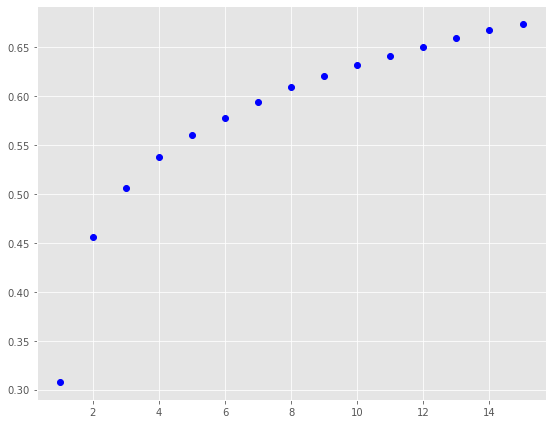

In [23]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 3

In [24]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [25]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 42)               

In [26]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 118s 81ms/step - loss: 2.7544 - accuracy: 0.3138
Epoch 2/15
1310/1310 [==============================] - 106s 81ms/step - loss: 2.1033 - accuracy: 0.4609
Epoch 3/15
1310/1310 [==============================] - 108s 82ms/step - loss: 1.8956 - accuracy: 0.5070
Epoch 4/15
1310/1310 [==============================] - 118s 90ms/step - loss: 1.7785 - accuracy: 0.5332
Epoch 5/15
1310/1310 [==============================] - 126s 96ms/step - loss: 1.6898 - accuracy: 0.5549
Epoch 6/15
1310/1310 [==============================] - 127s 97ms/step - loss: 1.6138 - accuracy: 0.5726
Epoch 7/15
1310/1310 [==============================] - 124s 95ms/step - loss: 1.5526 - accuracy: 0.5867
Epoch 8/15
1310/1310 [==============================] - 128s 98ms/step - loss: 1.4977 - accuracy: 0.6019
Epoch 9/15
1310/1310 [==============================] - 126s 96ms/step - loss: 1.4485 - accuracy: 0.6153
Epoch 10/15
1310/1310 [==============================] 

NameError: name 'val_acc' is not defined

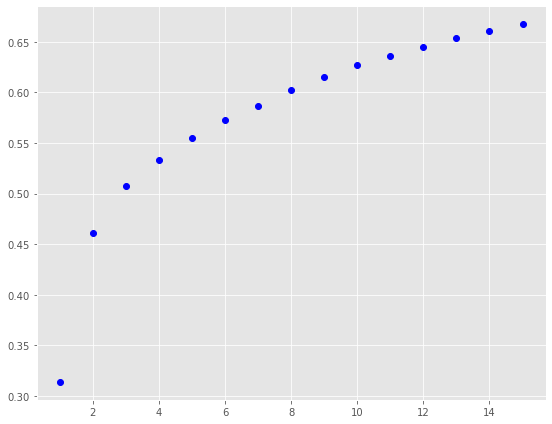

In [27]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 4

In [29]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [30]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 42)               

In [31]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 116s 81ms/step - loss: 2.8119 - accuracy: 0.2981
Epoch 2/15
1310/1310 [==============================] - 111s 85ms/step - loss: 2.1720 - accuracy: 0.4436
Epoch 3/15
1310/1310 [==============================] - 109s 83ms/step - loss: 1.9424 - accuracy: 0.4941
Epoch 4/15
1310/1310 [==============================] - 104s 79ms/step - loss: 1.8124 - accuracy: 0.5241
Epoch 5/15
1310/1310 [==============================] - 104s 79ms/step - loss: 1.7140 - accuracy: 0.5475
Epoch 6/15
1310/1310 [==============================] - 107s 82ms/step - loss: 1.6372 - accuracy: 0.5653
Epoch 7/15
1310/1310 [==============================] - 104s 79ms/step - loss: 1.5751 - accuracy: 0.5815
Epoch 8/15
1310/1310 [==============================] - 104s 80ms/step - loss: 1.5227 - accuracy: 0.5954
Epoch 9/15
1310/1310 [==============================] - 106s 81ms/step - loss: 1.4745 - accuracy: 0.6095
Epoch 10/15
1310/1310 [==============================] 

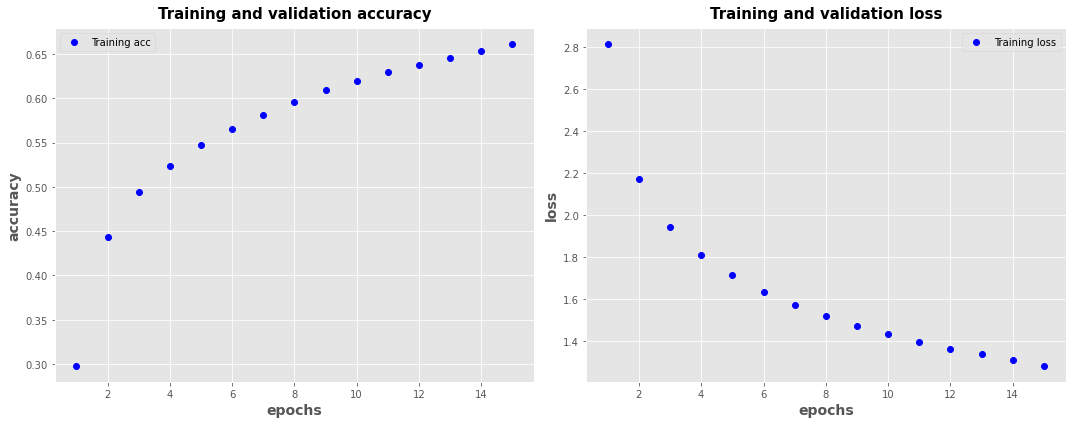

In [32]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 5

In [33]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57645


### Model training using embedding layer and RNN (Baseline)

In [34]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 70)            4035150   
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 42)               

In [35]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 110s 78ms/step - loss: 2.7712 - accuracy: 0.3088
Epoch 2/15
1310/1310 [==============================] - 104s 79ms/step - loss: 2.1762 - accuracy: 0.4432
Epoch 3/15
1310/1310 [==============================] - 107s 82ms/step - loss: 1.9334 - accuracy: 0.4979
Epoch 4/15
1310/1310 [==============================] - 104s 79ms/step - loss: 1.8049 - accuracy: 0.5266
Epoch 5/15
1310/1310 [==============================] - 105s 80ms/step - loss: 1.7113 - accuracy: 0.5503
Epoch 6/15
1310/1310 [==============================] - 109s 83ms/step - loss: 1.6344 - accuracy: 0.5682
Epoch 7/15
1310/1310 [==============================] - 107s 82ms/step - loss: 1.5772 - accuracy: 0.5828
Epoch 8/15
1310/1310 [==============================] - 107s 82ms/step - loss: 1.5224 - accuracy: 0.5972
Epoch 9/15
1310/1310 [==============================] - 108s 83ms/step - loss: 1.4749 - accuracy: 0.6096
Epoch 10/15
1310/1310 [==============================] 

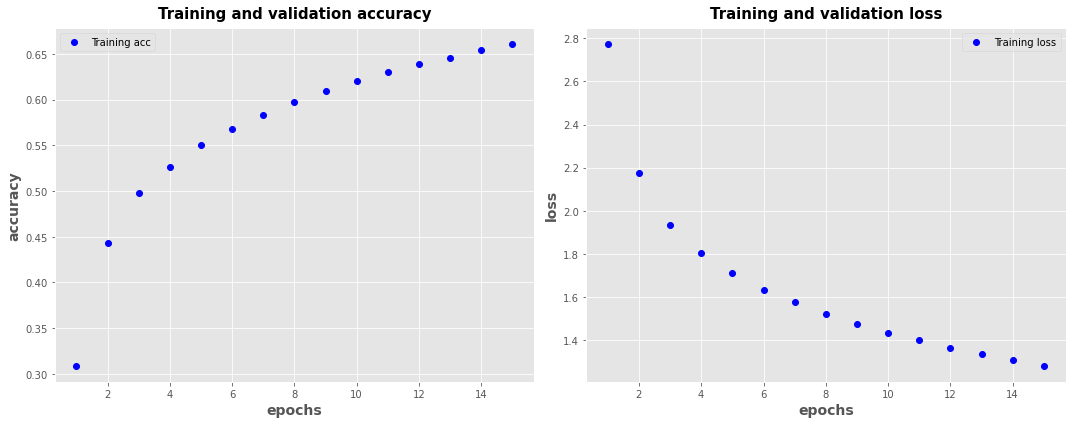

In [36]:
plot_loss_accuracy(history)